# Open in Colab
<a target="_blank" href="https://colab.research.google.com/github/Nicolepcx/ai-agents-the-definitive-guide/blob/main/CH02/ch02_swarms.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# About this Notebook

This notebook shows how to build and compile a **multi-agent swarm** using the `create_swarm` from [LangGraph Multi-Agent Swarm library](https://github.com/langchain-ai/langgraph-swarm-py). A swarm is a simple orchestration construct that allows multiple agents to collaborate, with one agent active by default and the others available to take over as needed.

## What it shows

* **Agent collaboration**: defines a swarm with two agents (`research_assistant` and `writer_assistant`).
* **Default active agent**: sets the `research_assistant` as the one that starts the conversation.
* **Compilation step**: calling `.compile()` finalizes the swarm into an executable app/graph that can process inputs and route them between agents.

## How it works

1. **Define agents**: elsewhere in the code, `research_assistant` and `writer_assistant` are each defined as tool-enabled agents with their own prompts or roles.
2. **Swarm creation**: `create_swarm()` takes these agent objects and constructs a collaborative structure.
3. **Default activation**: `default_active_agent="research_assistant"` ensures that research is initiated first, and only when needed does control move to the `writer_assistant`.
4. **Compilation**: `.compile()` returns a runnable object (often a LangGraph app) that manages state, routing, and message passing across agents.

## Why this pattern

* Keeps roles **modular**: each agent has its own tools and responsibilities.
* Provides **coordination**: the swarm acts as a supervisor that manages turn-taking.
* Easy to **extend**: more agents (editors, reviewers, validators) can be added without changing the orchestration logic.

## Extend and adapt

* Add a **validator agent** to check factual accuracy before the writer finalizes.
* Change the **default active agent** if you want drafting to begin before research.
* Add **routing rules** or scoring functions to decide which agent to hand off to.
* Persist swarm state with a checkpointer so multi-turn tasks can span sessions.

## Requirements and notes

* Requires `langgraph_swarm` or equivalent utilities installed.
* The agents passed to `create_swarm` must already be defined and tool-bound.
* Swarm behavior depends on how the agents are prompted—clear role definitions improve collaboration.

In [ ]:
!pip install -q \
    langchain==0.3.27 \
    langgraph==0.6.7 \
    langchain-openai==0.3.33 \
    langchain_experimental==0.3.4 \
    langchain_community==0.3.30 \
    langchain-tavily==0.2.11 \
    python-dotenv==1.1.1 \
    langchain-core \
    langgraph-swarm==0.0.14

# API Key Setup

In [ ]:
# Option 1 (preferred): create a `.env` file in your project folder with:
# OPENAI_API_KEY=your_openai_key_here
# TAVILY_API_KEY=your_tavily_key_here
#
# Option 2: set it directly in the notebook with magic:
# %env OPENAI_API_KEY=your_openai_key_here
# %env TAVILY_API_KEY=your_tavily_key_here

from dotenv import load_dotenv
import os

# Load from .env if available
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

# Fallback: ask if still missing
if not OPENAI_API_KEY:
    print("⚠️ OPENAI_API_KEY not found. You can set it with `%env` in the notebook or enter it below.")
    OPENAI_API_KEY = input("Enter your OPENAI_API_KEY: ").strip()

if not TAVILY_API_KEY:
    print("⚠️ TAVILY_API_KEY not found. You can set it with `%env` in the notebook or enter it below.")
    TAVILY_API_KEY = input("Enter your TAVILY_API_KEY: ").strip()

print("✅ API keys loaded successfully!")


# Imports

In [ ]:
import os
from typing import Annotated, List
from dotenv import load_dotenv

from langchain_openai import ChatOpenAI
from langchain_core.tools import tool

from langchain_community.document_loaders import WebBaseLoader
from langchain_tavily import TavilySearch

from langgraph.prebuilt import create_react_agent
from langgraph_swarm import create_swarm, create_handoff_tool


# Tools

In [ ]:
# Tavily web search
tavily_tool = TavilySearch(max_results=5).as_tool()

@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )


# Handoff tools

In [ ]:
to_writer = create_handoff_tool(
    agent_name="writer_assistant",
    description="Transfer to the writing assistant to synthesize sources into an answer.",
)
to_research = create_handoff_tool(
    agent_name="research_assistant",
    description="Return to the research assistant to fetch or scrape more sources.",
)

# LLM config

In [ ]:
# Uses OpenAI through LangChain. Set OPENAI_API_KEY in your environment.
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Agents

In [ ]:
research_assistant = create_react_agent(
    model=llm,
    tools=[tavily_tool, scrape_webpages, to_writer],
    prompt=(
        "You are a research assistant. Search the web with Tavily. "
        "When you have 3 to 5 solid sources, scrape key pages for details, "
        "then hand off to the writer assistant."
    ),
    name="research_assistant",
)

writer_assistant = create_react_agent(
    model=llm,
    tools=[to_research],
    prompt=(
        "You are a writing assistant. Read the provided Documents and messages. "
        "Synthesize a concise answer with citations by site name in brackets. "
        "If sources are thin or unclear, hand back to research with a short request."
    ),
    name="writer_assistant",
)

# Swarm

In [ ]:
swarm = create_swarm(
    agents=[research_assistant, writer_assistant],
    default_active_agent="research_assistant",
).compile()

# Run

In [ ]:
user_request = {
    "messages": [
        {
            "role": "user",
            "content": (
                "Find the current Swiss fintech licensing options for small startups. "
                "Gather authoritative sources and produce a short summary with three bullet points and references."
            ),
        }
    ]
}

for chunk in swarm.stream(user_request):
    print(chunk)
    print()


/tmp/ipython-input-338926207.py:18: LangChainBetaWarning: This API is in beta and may change in the future.
  tavily_tool = TavilySearch(max_results=5).as_tool()


{'research_assistant': {'messages': [HumanMessage(content='Find the current Swiss fintech licensing options for small startups. Gather authoritative sources and produce a short summary with three bullet points and references.', additional_kwargs={}, response_metadata={}, id='92bc972f-39c4-40a1-9c1d-c08aafc59ce9'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_P7xJzxBNz9GBKxqRP13Tml9z', 'function': {'arguments': '{"query":"Swiss fintech licensing options for startups 2024","search_depth":"advanced"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 2970, 'total_tokens': 2999, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl

In [ ]:
# Plot graph

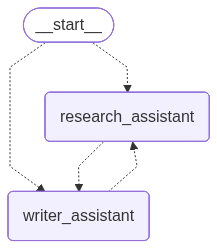

In [ ]:
from IPython.display import Image, display

display(Image(swarm.get_graph().draw_mermaid_png()))